In [1]:
from congress import Congress
api_key = 'fxzKX1XVwgCBfElNZlya7fwBVdEFNBlGEadiAFxD'
congress_api = Congress(api_key)
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
import csv
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)
import numpy as np
import importlib
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import CleanData, SaveState
importlib.reload(CleanData)
importlib.reload(SaveState)
from CleanData import clean_comment, get_bag_of_words

[nltk_data] Downloading package stopwords to /home/zchao3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Get stopword list
stop_words = stopwords.words('english')
number_strs = ['one', 'two', 'three', 'four', 'five', 'six', 'seven',\
'eight', 'nine', 'ten']
stop_words.extend(number_strs)

In [3]:
# Load tweet from members
filename = '../data/115_Senators_during_term.csv'
tweets_df = pd.read_csv(filename)

In [4]:
tweets_df = tweets_df.loc[tweets_df['full_text'].apply(type) == str]

In [5]:
usernames = tweets_df['user_name'].unique()

In [6]:
dem_train_users = ['Chuck Schumer', 'Elizabeth Warren', 'Bernie Sanders','Michael Bennet', \
                   'Cory Booker', 'Amy Klobuchar']
rep_train_users = ['McConnell', 'Rubio', 'John McCain', 'Ted Cruz']

In [7]:
test_users = tweets_df['user_name'].unique().tolist()
for user in (dem_train_users + rep_train_users):
    test_users.remove(user)

In [8]:
print('No. of democratic training tweets is',
tweets_df.loc[tweets_df['user_name'].isin(dem_train_users)].shape[0])
print('No. of republican training tweets is',
tweets_df.loc[tweets_df['user_name'].isin(rep_train_users)].shape[0])

No. of democratic training tweets is 19924
No. of republican training tweets is 13134


In [9]:
print('No. of testing tweets is',
tweets_df.loc[tweets_df['user_name'].isin(test_users)].shape[0])

No. of testing tweets is 220131


In [10]:
print(tweets_df.columns)

Index(['tweet_id', 'full_text', 'created_at', 'user_id', 'screen_name',
       'user_name', 'hashtags'],
      dtype='object')


In [11]:
tweets_df['clean_tweet'] = tweets_df['full_text'].apply(clean_comment)
bag_of_words, vectorizer = get_bag_of_words(tweets_df['clean_tweet'],ngram_range=(1,3), min_df=0.001)
print(bag_of_words.shape) 

(253189, 2647)


In [12]:
# Train binary multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics
def get_binary_NB_model(bag_of_words, df):
    # Training data:
    class1_words = bag_of_words[df['user_name'].isin(dem_train_users),:]
    class2_words = bag_of_words[df['user_name'].isin(rep_train_users),:]
    train_tweets = np.concatenate((class1_words,class2_words))
    labels = np.concatenate((np.zeros(class1_words.shape[0]),np.ones(class2_words.shape[0])))
    nb = ComplementNB()
    nb.fit(train_tweets, labels)
    # # Performance on training data
    predictions = nb.predict(train_tweets)
    print('Training Accuracy: ' + str(sum(labels==predictions)/len(labels)))
    # Compute the error.
    tn, fp, fn, tp = metrics.confusion_matrix(labels,predictions).ravel()
    print(tn, fp, fn, tp)
    return nb

In [13]:
# Train a naive bayes model on tweets from specified training users from each party.
nb_model = get_binary_NB_model(bag_of_words, tweets_df)

Training Accuracy: 0.8800290398693206
17418 2506 1460 11674


Apply model to remaining tweets. Add ‘nb_tweet_pred’ column to dataframe with resulting tweet predictions

In [14]:
# predictions = nb_model.predict(bag_of_words[tweets_df['user_name'].isin(test_users),:])
# tweets_df['nb_tweet_pred'] = np.NaN
# tweets_df.loc[tweets_df['user_name'].isin(test_users),['nb_tweet_pred']] = predictions
predict_probs = nb_model.predict_proba(bag_of_words)
tweets_df['dem_prob'] = predict_probs[:,0]
tweets_df['rep_prob'] = predict_probs[:,1]
tweets_df['nb_tweet_pred'] = nb_model.predict(bag_of_words)


In [15]:
def split_list(items, num_chunks):
    n = len(items)
    for i in range(num_chunks):
        yield items[int(i*n/num_chunks):int(min(n-1,(i+1)*n/num_chunks))]

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


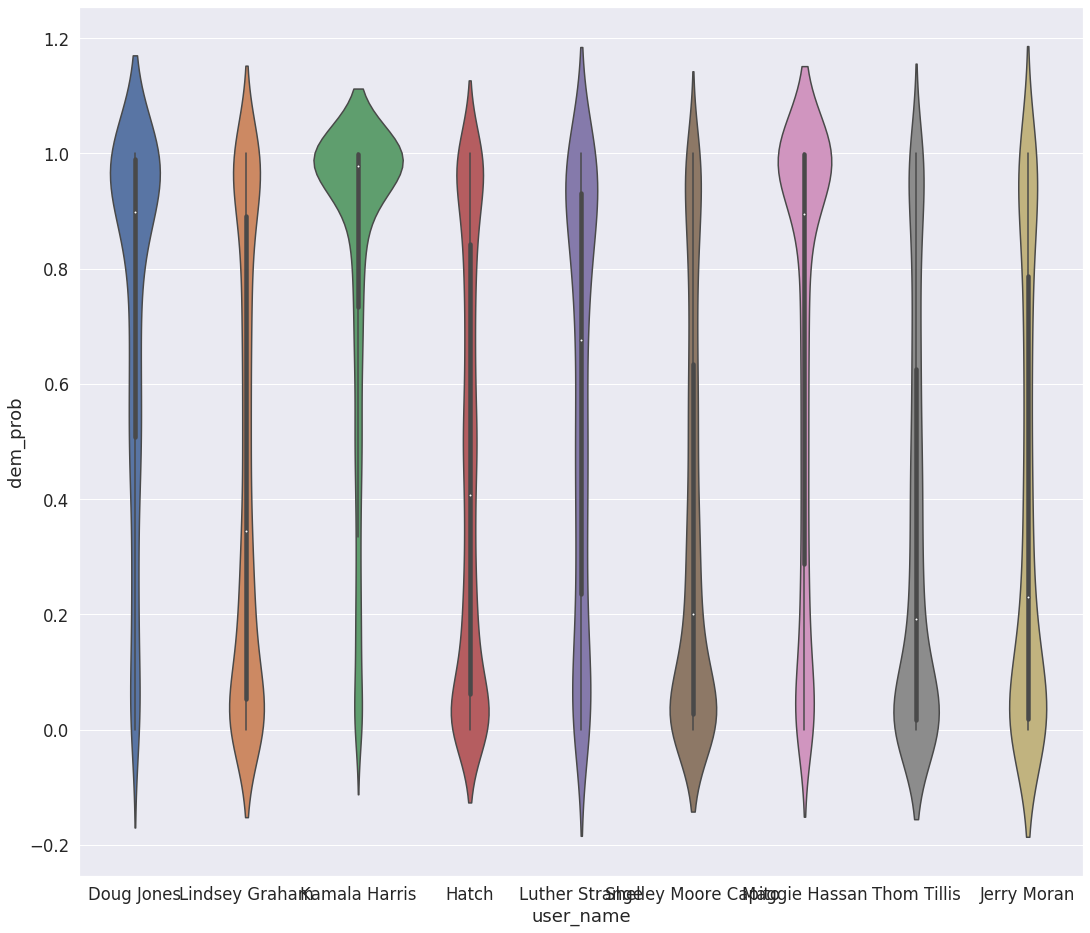

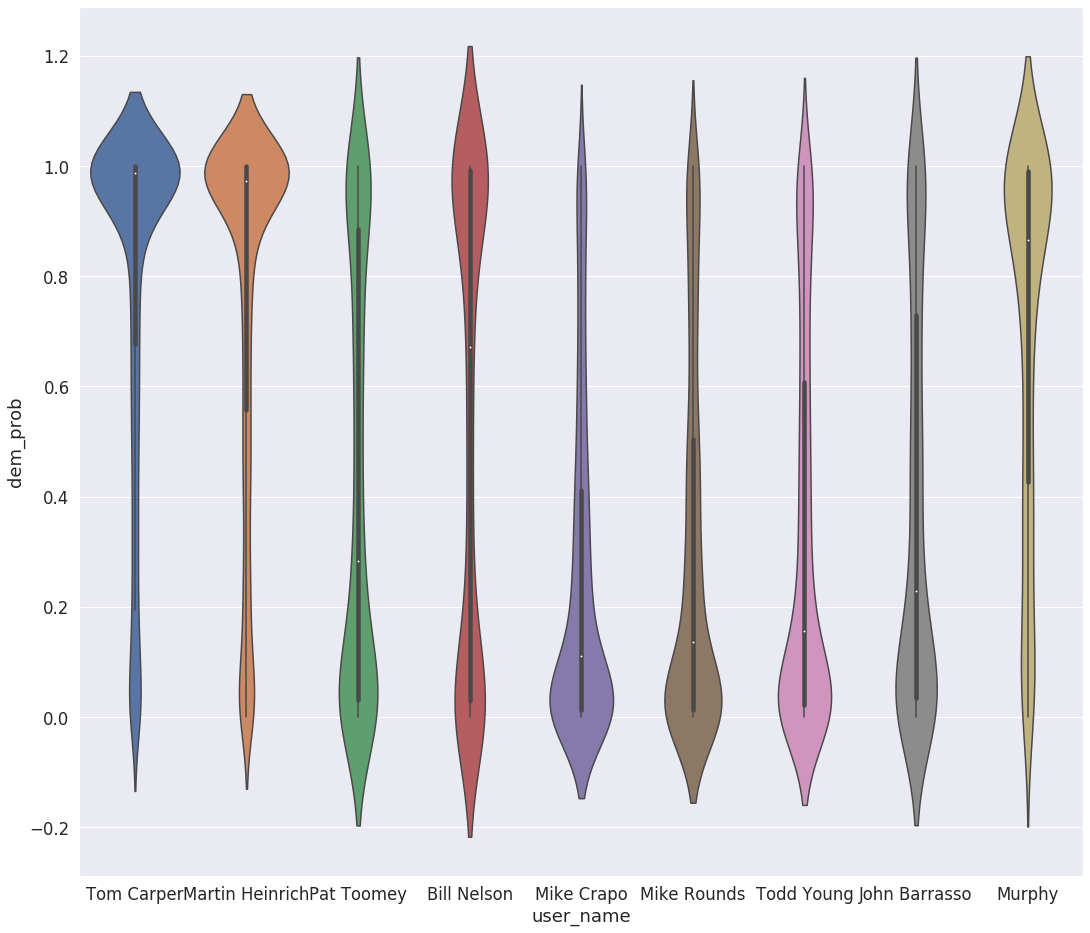

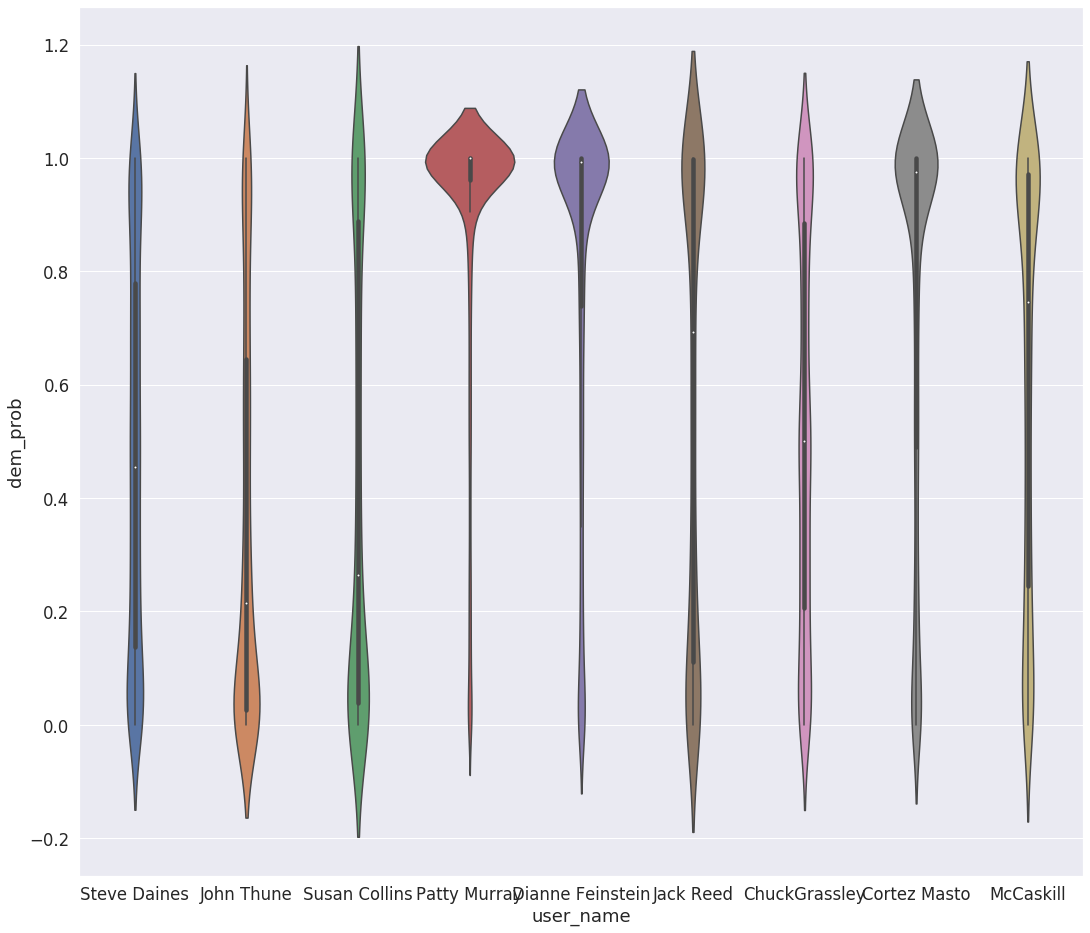

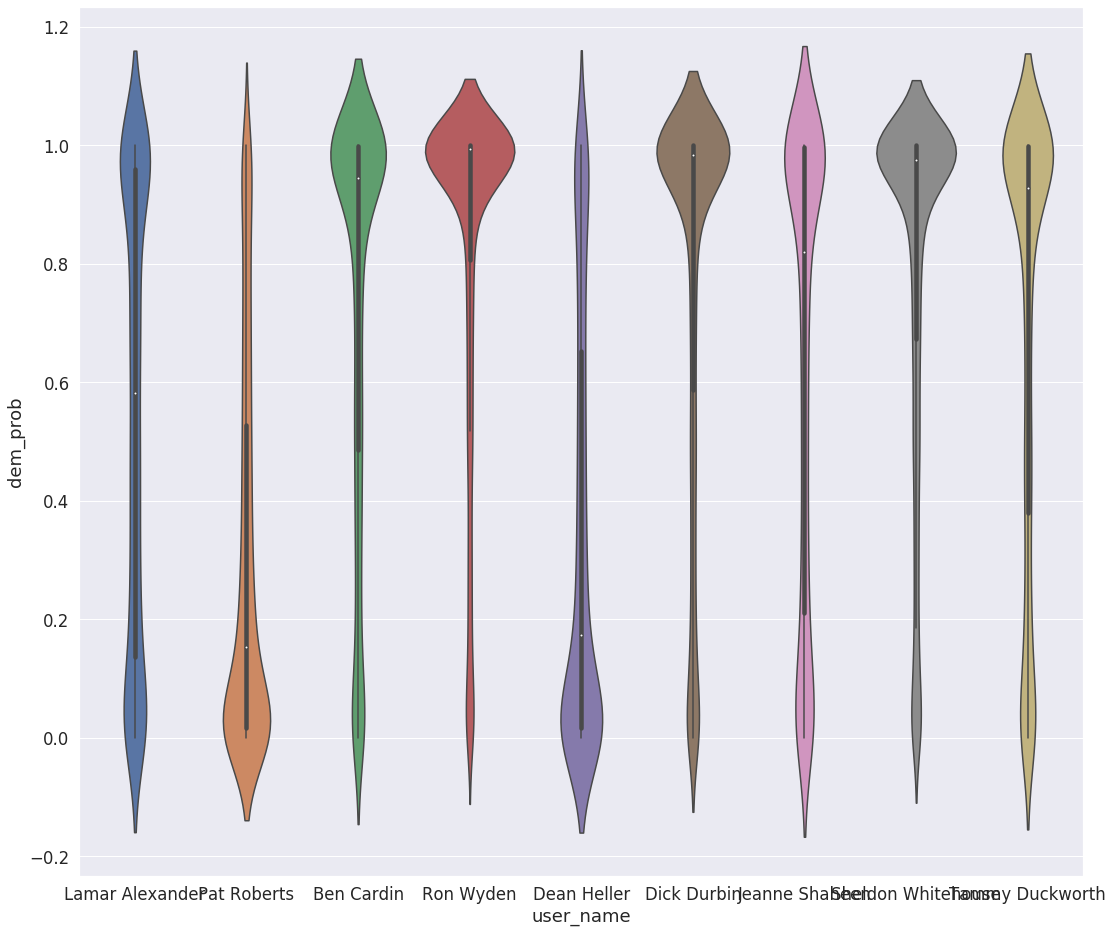

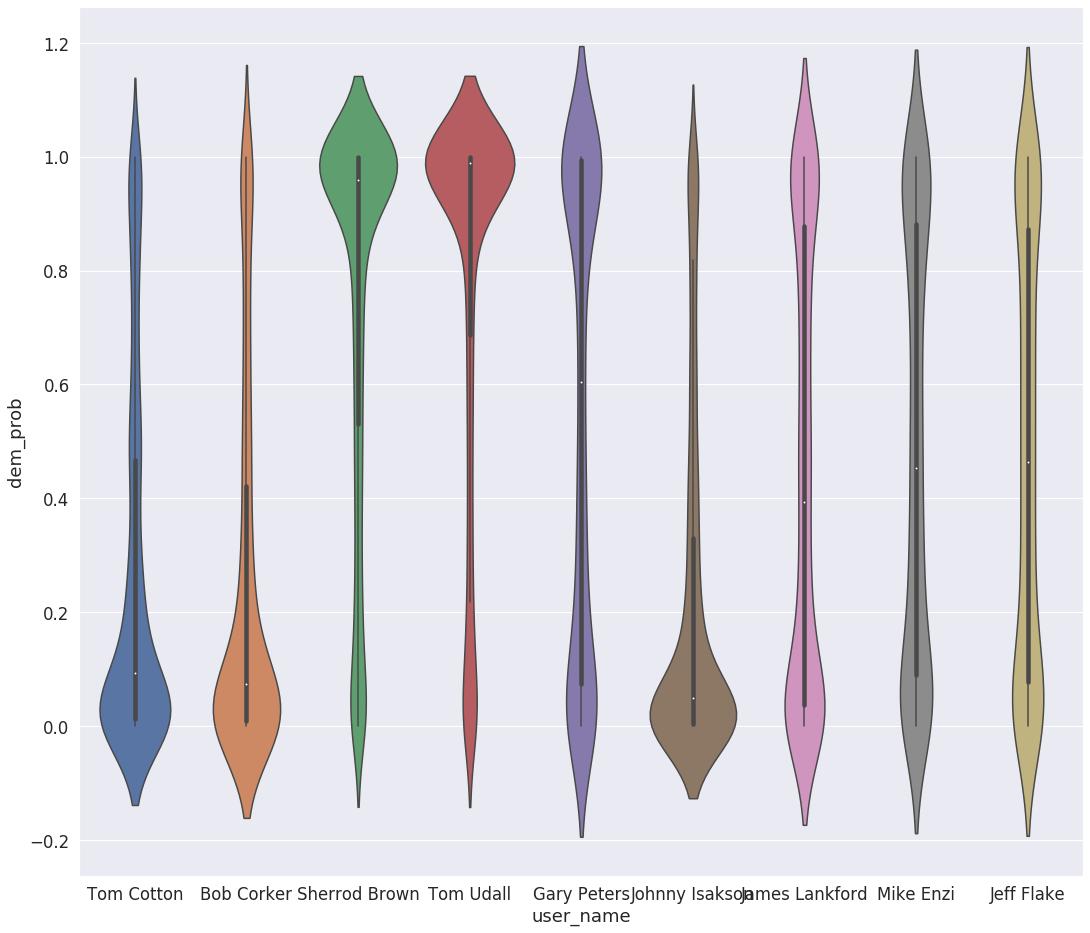

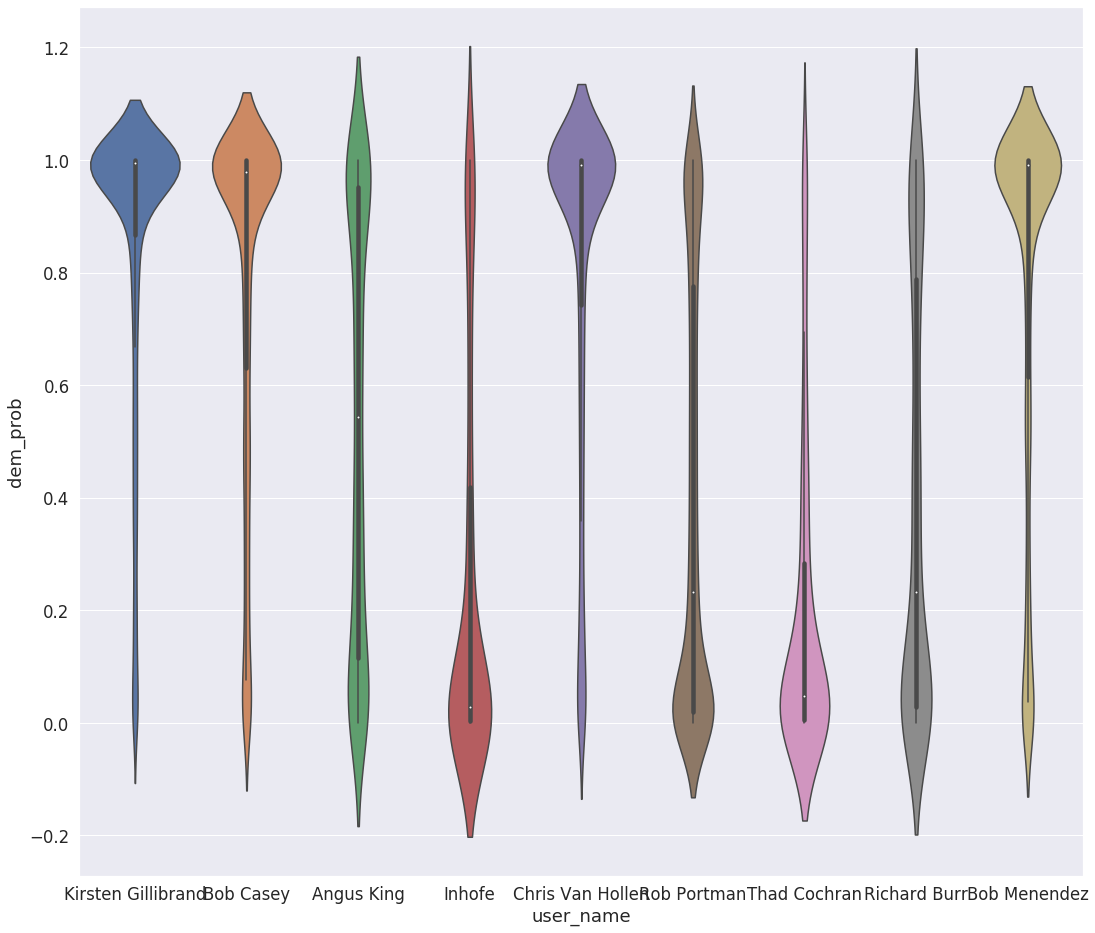

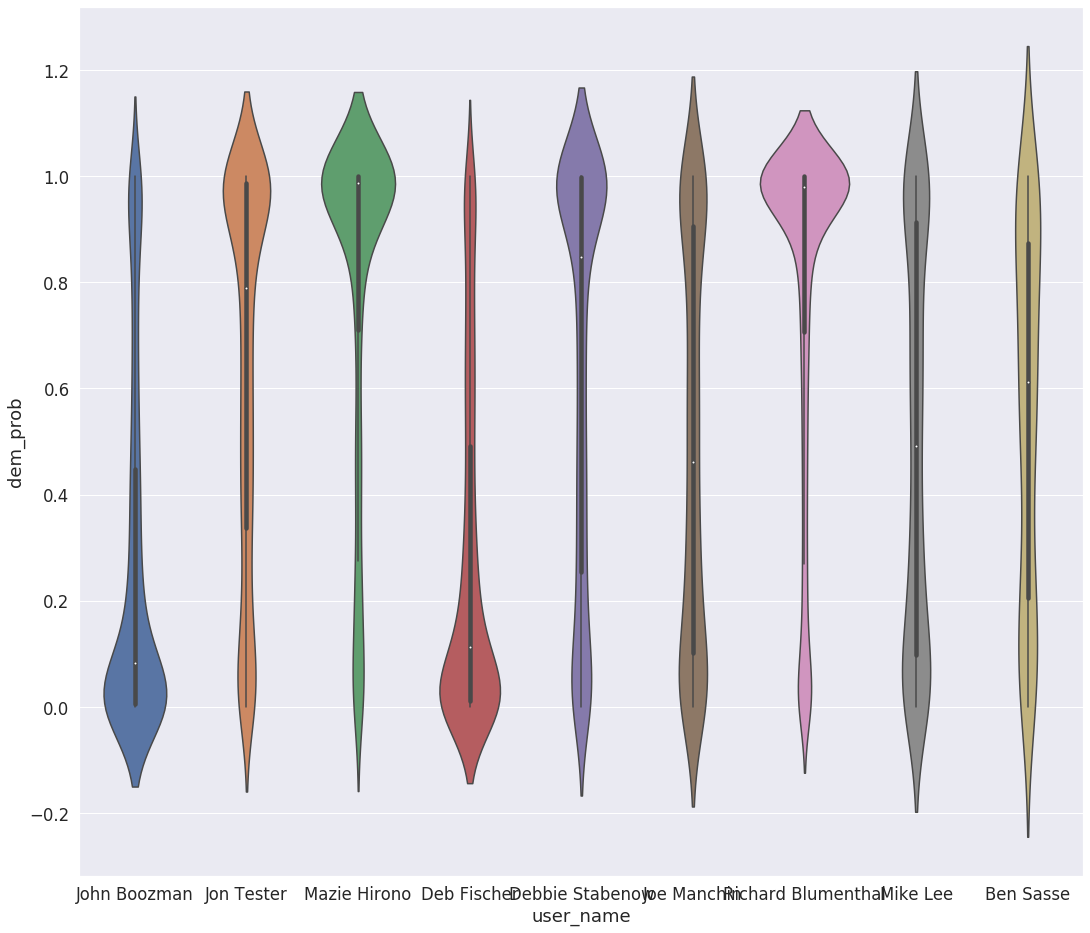

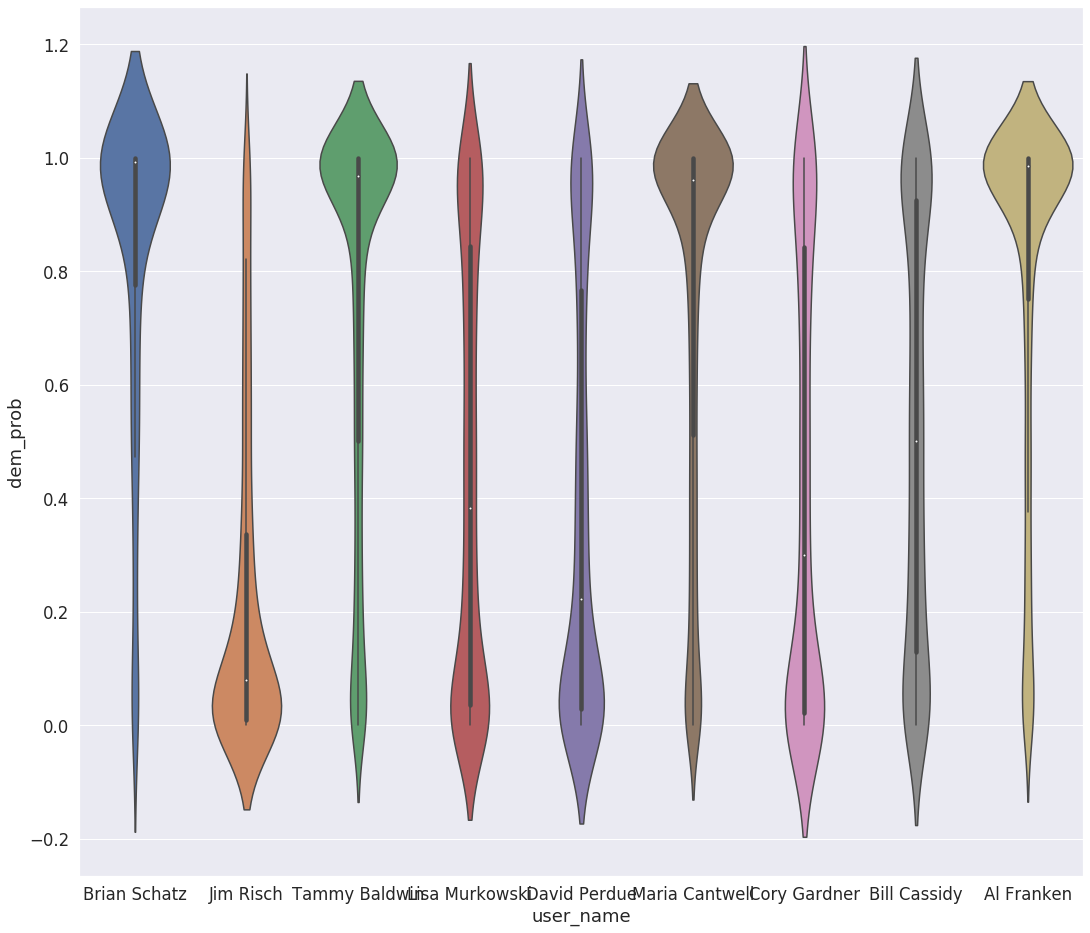

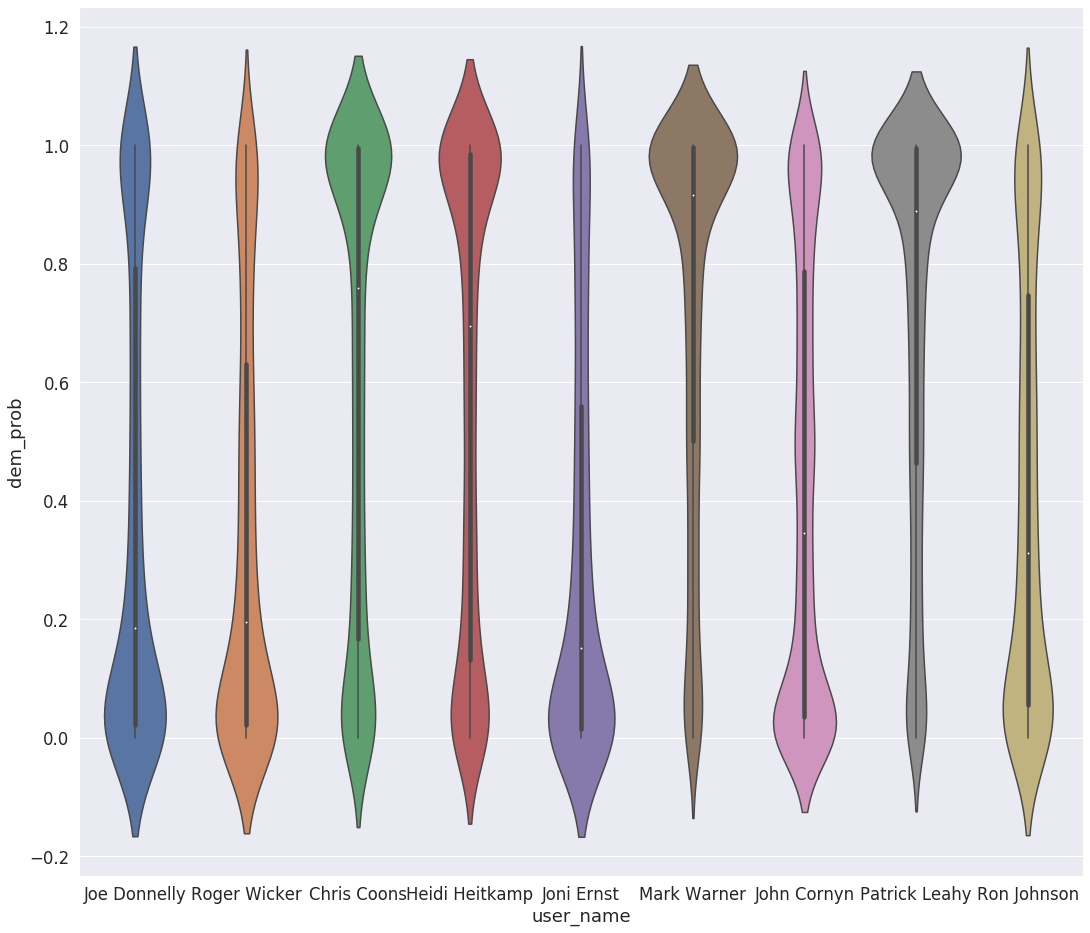

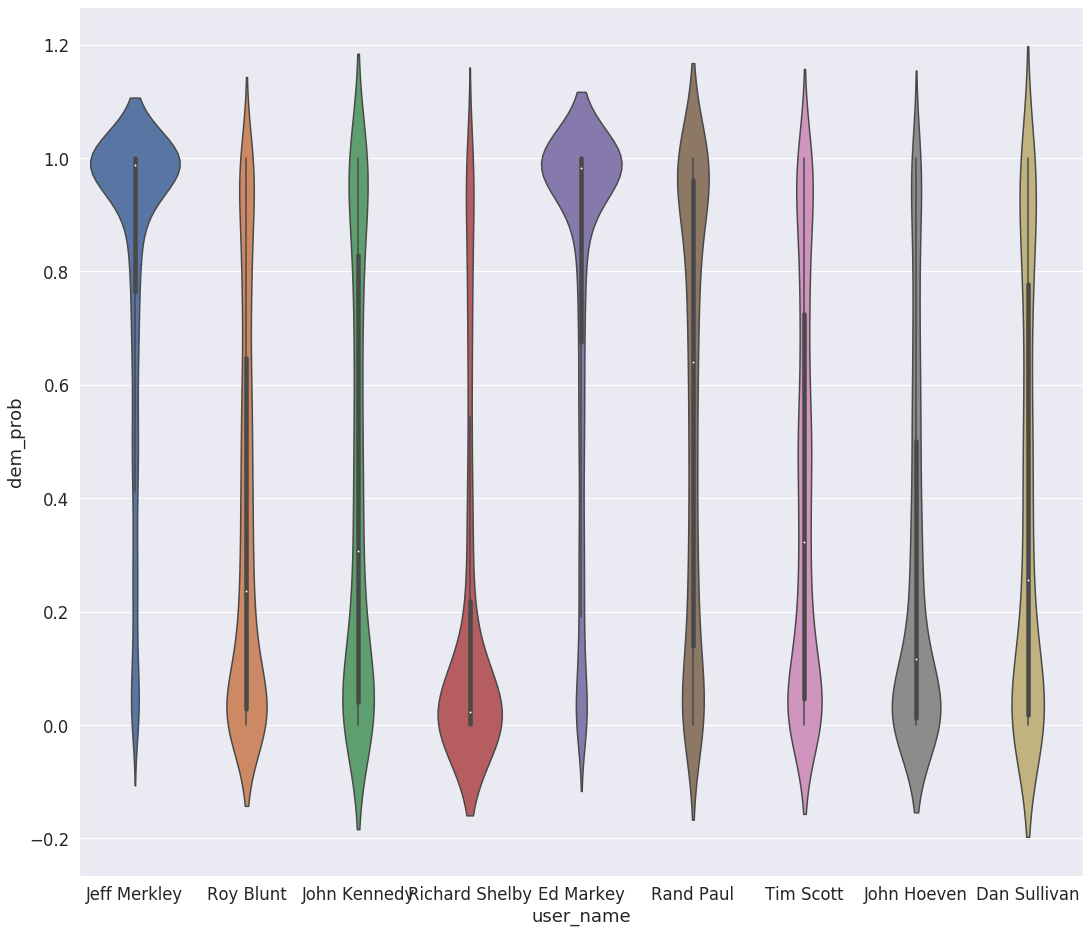

In [16]:
"""
Make scatter plots
"""
num_plots = 10
for some_users in split_list(test_users, num_plots):
    plt.figure(figsize=(18, 16))
    sns.violinplot(x='user_name', y='dem_prob', data=tweets_df.loc[tweets_df['user_name'].isin(some_users)])

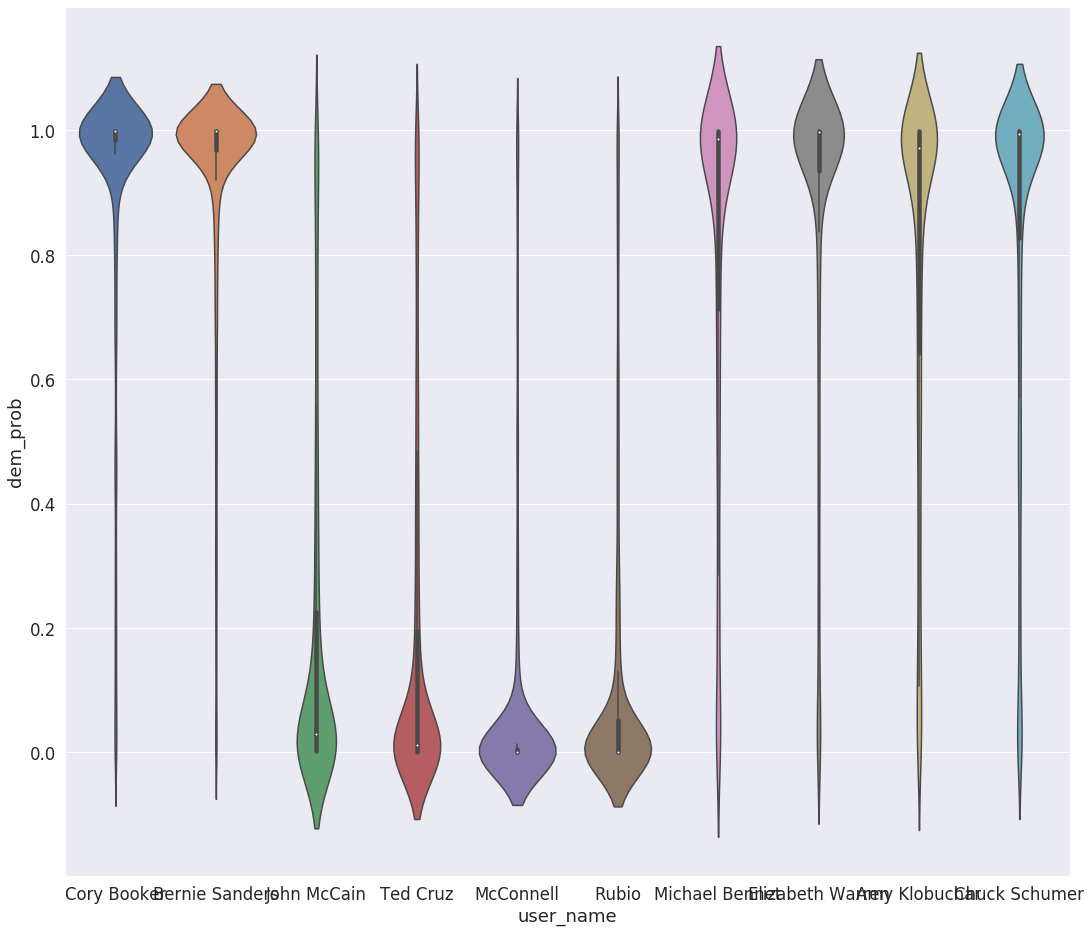

In [17]:
"""
Make scatter plots for training set
"""
train_users = dem_train_users + rep_train_users
plt.figure(figsize=(18, 16))
sns.violinplot(x='user_name', y='dem_prob', data=tweets_df.loc[tweets_df['user_name'].isin(train_users)])

In [18]:
def nmf(df, data_col_name, num_topics=10, verbose=True, stop_words=None):
    ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2),min_df=0.001, stop_words=stop_words)
    bag_of_words = ngram_vectorizer.fit_transform(df[data_col_name].values.astype(str)).toarray()
    idx_to_word = np.array(ngram_vectorizer.get_feature_names())
    # apply NMF
    nmf = NMF(n_components=num_topics)
    W = nmf.fit_transform(bag_of_words)
    H = nmf.components_
    if verbose:
        for i, topic in enumerate(H):
            print("Topic {}: {}".format(i + 1,",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))
    return nmf, ngram_vectorizer

In [19]:
dem_nmf = nmf(tweets_df.loc[tweets_df['dem_prob']>0.9], 'clean_tweet', stop_words=stop_words)

Topic 1: admin,communities,potus,rural,jobs,public,economy,protect,families,amp
Topic 2: health insurance,americans,care bill,coverage,access,insurance,affordable,health care,care,health
Topic 3: policy,pres trump,pres,trump admin,admin,trump administration,administration,president trump,president,trump
Topic 4: senator,thank,senwhitehouse,says,senmarkey,rt senatedems,senatedems,sen,corybooker,rt
Topic 5: every,time,work,help,country,get,us,today,make,need
Topic 6: tax bill,pass,republicans,care bill,house,vote,gop,bipartisan,senate,bill
Topic 7: corporations,middle class,middle,class,gop,tax cuts,cuts,plan,families,tax
Topic 8: conditions,preexisting,republicans,young people,young,kavanaugh,deserve,american people,american,people
Topic 9: aca,millions,medicaid,insurance,million,coverage,bill would,trumpcare,americans,would
Topic 10: children,gun,dreamers,investigation,congress must,pass,protect,act,congress,must


In [20]:
rep_nmf = nmf(tweets_df.loc[tweets_df['rep_prob']>0.9], 'clean_tweet', stop_words=stop_words)

Topic 1: continue,communities,nd,families,amp women,jobs,work,support,help,amp
Topic 2: years,office,enjoyed,joined,met,today discuss,hearing,meeting,discuss,today
Topic 3: rt foxnews,rt senategop,senorrinhatch,senategop,foxnews,marcorubio,johncornyn,rt senatemajldr,senatemajldr,rt
Topic 4: support,committee,senate floor,help,act,floor,passed,bipartisan,bill,senate
Topic 5: por,del,de la,para,que,los,en,el,la,de
Topic 6: morning,state,great news,students,meeting,meet,news,see,work,great
Topic 7: korea,national,district,keep,safe,china,must,security,us senate,us
Topic 8: floor,pm,discuss,speaking,morning,tune,watch live,hearing,live,watch
Topic 9: state,new,work,looking forward,looking,forward working,working,look forward,look,forward
Topic 10: men women,day,country,men,nation,women,honor,thank,veterans,service


In [21]:
media_df = pd.read_csv('../data/news_outlets_50K.csv')
media_df = media_df[['user_screen_name', 'id', 'text', 'created_at']]
import preprocessor as p
media_df['text']  = media_df['text'].apply(p.clean)
media_df = media_df.rename(columns={"user_screen_name": "user_name", "text": "clean_tweet"}) 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
tweets_df2 = tweets_df.append(media_df, ignore_index=True, sort=False)

(253189, 2647)


In [25]:
bag_of_words, vectorizer = get_bag_of_words(tweets_df2['clean_tweet'],ngram_range=(1,3), min_df=0.001)
print(bag_of_words.shape) 

(304579, 2460)


In [27]:
nb_model = get_binary_NB_model(bag_of_words, tweets_df2)

Training Accuracy: 0.8775485510315204
17411 2513 1535 11599


In [29]:
predict_probs = nb_model.predict_proba(bag_of_words)
tweets_df2['dem_prob'] = predict_probs[:,0]
tweets_df2['rep_prob'] = predict_probs[:,1]
tweets_df2['nb_tweet_pred'] = nb_model.predict(bag_of_words)

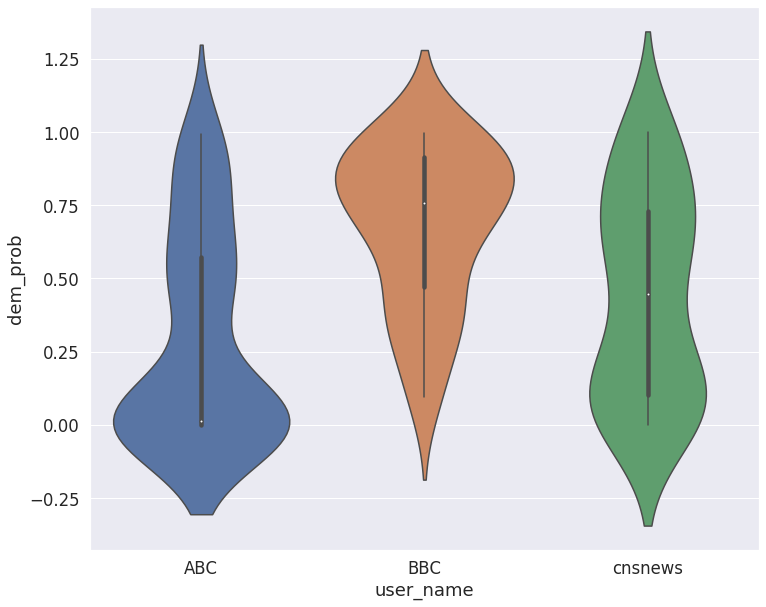

In [72]:
plt.figure(figsize=(12, 10))
medias = ['cnsnews', 'ABC', 'BBC']
sns.violinplot(x='user_name', y='dem_prob', data=tweets_df2.loc[tweets_df2['user_name'].isin(medias)])

In [73]:
# Our current dataset does not have too much tweets from the medias in the chart:
count = 0
names = tweets_df2['user_name']
for row in names:
    if row == 'ABC':
        count = count+1
count

69

In [75]:
count = 0
names = tweets_df2['user_name']
for row in names:
    if row == 'Ted Cruz':
        count = count+1
count

4294